In [1]:
import os
import cv2
import skimage

import numpy as np
import sklearn
import pandas as pd  
import tensorflow as tf

from keras.models import load_model
from mtcnn import MTCNN
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns
import inspect 

import mpld3


2023-08-25 21:40:53.510559: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from face_embedding import face_embedding
from face_detection import face_cropping, l2_normalize
from save_file import save_data

In [3]:
sklearn.__version__

'1.3.0'

In [4]:
# check the code 
a = inspect.getsourcelines(MTCNN)  
with open('mtcnn_code.py','w') as f:
    f.write(''.join(a[0]))
!atom mtcnn_code.py

In [5]:
# path to extract the names of the dictionary : repo name = celebrity name
gallery_path = '../data/galleries/'

person_paths = {}
for name in os.listdir(gallery_path):
    dir_name = os.path.join(gallery_path, name)
    if os.path.isdir(dir_name):
        person_paths[name] =  dir_name
person_paths

{'Q295093': '../data/galleries/Q295093',
 'Q933434': '../data/galleries/Q933434',
 'Q1210514': '../data/galleries/Q1210514'}

In [6]:
# deep face 
#model_path = '../data/models/deepface/keras/deepface_fn_512.h5'
#model_path = '../data/models/deepface/keras/deepface_fn_128.h5'

# face net
#model_path = '../data/models/facenet/keras/facenet_ds_keras_128.h5'
model_path = '../data/models/facenet/keras/facenet_ds_keras_512.h5'

model_emb = load_model(model_path, compile = False , custom_objects={"tf": tf})


/Users/aro/virtualenvs/benchmark-face-reco-YqF_etr5/lib/python3.9/site-packages/keras/src/layers/core/lambda_layer.py:327: UserWarning: FaceNet is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(


In [7]:
# Save files : crop faces and metadata
path_arrays = "../data/embeddings/"

# metadata from the dataset
# files_id                              7b50733819894f0e96756b79e9ef93df
# video_title          Claude Lelouch et Didier Barbelivien : ils ont...
# video_url                  https://www.youtube.com/watch?v=lwfKc4HuuCk
# program_name                                         Vivement Dimanche
# all_personalities                   ['Q933434', 'Q295093', 'Q1210514']
# video_length                                              00:01:42.000

array_name = "celebrities_7b50733819894f0e96756b79e9ef93df"
file_emb_celeb_np = path_arrays + array_name
file_metadata_json = path_arrays + array_name

# Hyperparamters for cropping
# Contour margin for the face cropping
margin = 0
min_crop_ratio = 0.05  # minimum ratio size of the image / size of the face crop
image_size = 160  # after resizing to compute to embeddings
min_face_size = 120  # in the face detection process
metadata_celeb = {
    'filename_metadata': file_metadata_json + '.json',
    'filename_embeddings': file_emb_celeb_np + '.npz',
    'face_detection': 'MTCNN',
    'model_emb': 'facenet_ds_keras_512.h5',
    'persons': ['Q933434', 'Q295093', 'Q1210514'],
    'crop_margin': margin,
    'min_face_size': min_face_size,
    'min_crop_ratio': min_crop_ratio,
    'image_size': image_size,
}

In [8]:
# MTCNN model
face_detector = MTCNN(min_face_size=min_face_size)

# faces
faces_embeddings = {}

for person_id, person_path in person_paths.items():

    for file_name in os.listdir(person_path):

        file_name_path = person_path + '/' + file_name
        image_np = cv2.cvtColor(cv2.imread(file_name_path), cv2.COLOR_BGR2RGB)

        face_crop = face_cropping(image_np, face_detector,
                                  max_nb_faces=1,
                                  margin=margin,
                                  image_size=image_size,
                                  flag_normalise=False,
                                  min_crop_ratio = min_crop_ratio,
                                  flag_plot=True)
        if face_crop.size > 0:
            face_emb = face_embedding(model_emb, face_crop)
            faces_embeddings[file_name] = face_emb[0] # the output is a list to manage chunks

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step


In [9]:
faces_emb_celeb_np = np.array(list(faces_embeddings.values()))
labels = list(faces_embeddings.keys())

# instantiate the tsne 
tsne = TSNE(n_iter=1500, n_components=2, perplexity=10)
# fit
embs_tsne = tsne.fit_transform(faces_emb_celeb_np)

# Visualisation of the embeddings space 

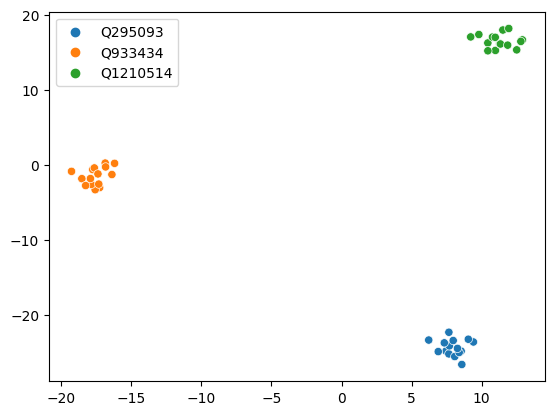

In [10]:

label_legend = [ label.split('.')[0].split('_')[0] for label in labels ]

mpld3.enable_notebook()

x = embs_tsne[:, 0]
y = embs_tsne[:, 1]

fig, ax = plt.subplots()
sns.scatterplot(x=x, y=y, hue=label_legend)
plt.show()

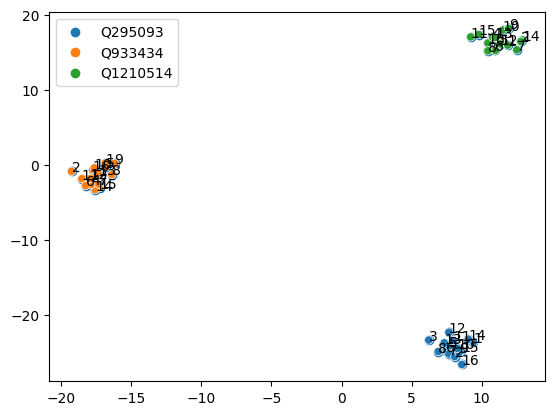

In [11]:
# visualise the inndex of the gallery : usefull when there is an overlap
# i.e bad quality embeddings

label_annot = [ label.split('.')[0].split('_')[1] for label in labels ]

fig, ax = plt.subplots()
ax.scatter(x, y)

p1 = sns.scatterplot(x=x, y=y, hue=label_legend)
for i, txt in enumerate(label_annot):
    p1.annotate(txt, (x[i], y[i]))
plt.show()

In [12]:
label_save = np.array([ label.split('.')[0].split('_')[0] for label in labels ])
save_dict = {}
save_dict['embeddings'] = faces_emb_celeb_np
save_dict['person_id'] = label_save
save_dict

{'embeddings': array([[ 0.27025014, -0.5268065 ,  1.6861575 , ...,  0.07924218,
         -0.5792029 , -0.77166486],
        [ 0.85563695, -0.8748164 ,  1.7097588 , ..., -0.28445446,
         -1.3723154 , -0.23372388],
        [ 0.00217373, -0.9179455 ,  0.62329996, ...,  0.5472627 ,
         -1.0209224 , -1.1353889 ],
        ...,
        [ 1.022533  ,  0.6523293 , -1.3205392 , ..., -0.21819986,
          0.20691489,  0.6407849 ],
        [ 0.7902241 ,  0.48310834,  0.36629528, ...,  0.35637838,
          0.17035621, -0.90919554],
        [ 1.176565  , -0.6995643 ,  0.50866306, ..., -0.4199344 ,
         -0.06428968,  1.0472914 ]], dtype=float32),
 'person_id': array(['Q295093', 'Q295093', 'Q295093', 'Q295093', 'Q295093', 'Q295093',
        'Q295093', 'Q295093', 'Q295093', 'Q295093', 'Q295093', 'Q295093',
        'Q295093', 'Q295093', 'Q295093', 'Q933434', 'Q933434', 'Q933434',
        'Q933434', 'Q933434', 'Q933434', 'Q933434', 'Q933434', 'Q933434',
        'Q933434', 'Q933434', 'Q933

In [13]:
save_data(file_emb_celeb_np, save_dict, file_metadata_json, metadata_celeb)

In [14]:
#load embeddings
file_name = file_emb_celeb_np + '.npz'
a = np.load(file_name)

In [15]:
a['embeddings']

array([[ 0.27025014, -0.5268065 ,  1.6861575 , ...,  0.07924218,
        -0.5792029 , -0.77166486],
       [ 0.85563695, -0.8748164 ,  1.7097588 , ..., -0.28445446,
        -1.3723154 , -0.23372388],
       [ 0.00217373, -0.9179455 ,  0.62329996, ...,  0.5472627 ,
        -1.0209224 , -1.1353889 ],
       ...,
       [ 1.022533  ,  0.6523293 , -1.3205392 , ..., -0.21819986,
         0.20691489,  0.6407849 ],
       [ 0.7902241 ,  0.48310834,  0.36629528, ...,  0.35637838,
         0.17035621, -0.90919554],
       [ 1.176565  , -0.6995643 ,  0.50866306, ..., -0.4199344 ,
        -0.06428968,  1.0472914 ]], dtype=float32)

In [16]:
a['person_id']

array(['Q295093', 'Q295093', 'Q295093', 'Q295093', 'Q295093', 'Q295093',
       'Q295093', 'Q295093', 'Q295093', 'Q295093', 'Q295093', 'Q295093',
       'Q295093', 'Q295093', 'Q295093', 'Q933434', 'Q933434', 'Q933434',
       'Q933434', 'Q933434', 'Q933434', 'Q933434', 'Q933434', 'Q933434',
       'Q933434', 'Q933434', 'Q933434', 'Q933434', 'Q933434', 'Q933434',
       'Q1210514', 'Q1210514', 'Q1210514', 'Q1210514', 'Q1210514',
       'Q1210514', 'Q1210514', 'Q1210514', 'Q1210514', 'Q1210514',
       'Q1210514', 'Q1210514', 'Q1210514', 'Q1210514', 'Q1210514'],
      dtype='<U8')